# Spam Comments Detection

## Tahap 1: Data Preparation and Data Cleaning
------------------------------------------------

##### **Daftar Isi pada Notebook**
1. Background - Latar belakang pembuatan projek dan sumber data yang digunakan hingga tujuan penelitian
2. Notebook Setup - mengimport package dan data
3. Overview data
5. Data Cleaning
   - remove duplicate comments
   - replace slangwords
   - remove stopwords
   - remove white spaces
6. Feature Extraction
    - url_ratio
    - word_duplicate
7. Export data yang telah dilakukan prepocessing kedalam format .csv

------------------------------------------------------

**1. Background**

**Latar Belakang Project**



**Tujuan Project**
Pada project kali ini pendeteksian komentar spam dilakukan untuk menemukan komentar yang tidak relevan berisikan "promosi" sehingga hasilnya dapat digunakan untuk mengetahui sebuah komentar yang relevan dengan konten videonya. 


---------------------------------------------------

**Sumber Data**

Data yang digunakan berasal dari YouTube dengan melakukan crawling data menggunakan YouTube Data API. Mengekstrak dataset berdasarkan query yang telah dipilih, kemudian untuk memperoleh komentar dengan videoId menggunakan videoId.

Metadata yang dipilih anatara lain:
- videoId
- Tittle Video
- Name (username)
- Commment
- CommentId
- Time
- Like
- Reply Count
- Label

---------------------------------------------------

**Notebook Setup**

In [1]:
import pandas as pd
import glob
import os
import regex as re
import emoji
import pandas as pd
import numpy as np
import time
import string
from string import punctuation
import seaborn as sns
import emoji
from unidecode import unidecode 
import datetime
import collections
import spacy
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
from tqdm import tqdm
from textblob import TextBlob
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
#from spacy.lang.id import Indonesian
#from spacy.lang.id.stop_words import STOP_WORDS
import warnings; warnings.simplefilter('ignore')

In [9]:
df = pd.read_csv("..\Data\Data Label\Data_3003_Label.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3003 entries, 0 to 3002
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Video_Id     3003 non-null   object 
 1   Tittle       3003 non-null   object 
 2   Description  3003 non-null   object 
 3   Name         3003 non-null   object 
 4   Comment      3003 non-null   object 
 5   Comment_Id   3003 non-null   object 
 6   Time         3003 non-null   object 
 7   Likes        3003 non-null   int64  
 8   Reply_Count  2624 non-null   float64
 9   Label        3003 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 234.7+ KB


In [10]:
df["Label"] = df["Label"].astype("category")
df["Time"] = df["Time"].astype("datetime64")

In [11]:
df.head()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0.0,spam
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Akiru Syakir,Bantu subscribe youtube gw dong,UgwQM2OHIzkVDtu0PIN4AaABAg,2019-04-10 22:40:00,0,0.0,spam
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teguh Wage Prakoso,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,2019-04-09 02:50:06,0,NaN,spam
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,hidayah,https://www.youtube.com/channel/UC_iQ1hcNxz1ir...,UgxA-h0VMWXoShPkFEZ4AaABAg,2019-04-10 12:25:49,0,0.0,spam
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Derisma Ae,"https://youtu.be/aS1FIPcCuh4 CH: Derisma ae, m...",UgybtnYbYjDF7YZJAdN4AaABAg,2019-04-15 16:00:05,0,0.0,spam


In [12]:
data = df.drop_duplicates(subset=["Comment"], keep=False)

In [13]:
B, K = data.shape
print(f"Banyaknya Saat ini adalah Baris: {B} dan Kolom: {K}")

Banyaknya Saat ini adalah Baris: 2847 dan Kolom: 10


In [14]:
data.isnull().sum()

Video_Id         0
Tittle           0
Description      0
Name             0
Comment          0
Comment_Id       0
Time             0
Likes            0
Reply_Count    350
Label            0
dtype: int64

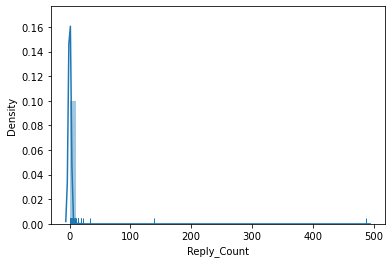

In [15]:
p = sns.distplot(data['Reply_Count'], kde=True, rug=True)

In [16]:
data['Reply_Count'].fillna(data['Reply_Count'].median(),inplace=True)

In [17]:
data.isnull().sum()

Video_Id       0
Tittle         0
Description    0
Name           0
Comment        0
Comment_Id     0
Time           0
Likes          0
Reply_Count    0
Label          0
dtype: int64

In [18]:
data["Reply_Count"] = data["Reply_Count"].astype("int64")

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2847 entries, 0 to 3002
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Video_Id     2847 non-null   object        
 1   Tittle       2847 non-null   object        
 2   Description  2847 non-null   object        
 3   Name         2847 non-null   object        
 4   Comment      2847 non-null   object        
 5   Comment_Id   2847 non-null   object        
 6   Time         2847 non-null   datetime64[ns]
 7   Likes        2847 non-null   int64         
 8   Reply_Count  2847 non-null   int64         
 9   Label        2847 non-null   category      
dtypes: category(1), datetime64[ns](1), int64(2), object(6)
memory usage: 225.3+ KB


In [20]:
#count comments words length
def count_length(text):
    return len(text)

In [21]:
data['Length_Comment'] = data['Comment'].apply(lambda x: count_length(x))

In [22]:
data.sample(10)

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
1768,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Muhammad Arief Zaky,Konten ini lebih menghibur dan berbobot daripa...,UgyZ_t26GTtI649SpKR4AaABAg,2019-04-10 03:54:04,44,0,legitimate,87
339,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Twilight ZS,Jgn lupa mampir ke channel gua🤫🤫,UgyHd10phpOlkxHdIYp4AaABAg.9HoRZYPjUKn9I7T3hEJFE7,2021-01-05 07:51:38,0,0,spam,32
1958,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Jeon Kookie,Anda yg gak jelas,Ugxl4UGFZ0EyKIz9UuR4AaABAg.8tg_7O5qzeL8tg_YtY-HAR,2019-04-14 02:53:28,0,0,legitimate,17
2844,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ti Ga,WAJIB TRENDING!,UgwWcgRpzcCBf3y10zN4AaABAg,2019-04-08 14:47:57,0,0,legitimate,15
2458,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Yogi RY,Merinding gw dengerinnya asli :'),UgwOhL03gz0XssKnDAd4AaABAg,2019-04-13 05:24:00,0,0,legitimate,33
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0,spam,28
207,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Pacok Creator,Otw 2 Juta Subscriber Nih ? Punya Janji Apa Ba...,Ugz4-iZKjzMpNfZzm6B4AaABAg,2019-04-12 12:10:30,4,0,spam,195
691,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Suwandi Kurniawan,https://youtu.be/7gOEHlNuAok ayo nntn gais...,Ugxlk3i5phHVrjYlwVp4AaABAg,2019-04-11 06:19:50,0,0,spam,45
1503,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ahmad Rifandi,"Seperti yang disampaikan bung karno(coki), per...",Ugyjg2SVlEF3wFQKl3d4AaABAg,2019-04-13 16:33:32,6,0,legitimate,207
2342,LU2p56QVUWA,Debat Jokowi Vs Prabowo Soal Ideologi &amp; Pe...,DebatCapres #DebatJokowiPrabowo #DebatKeempatC...,Tralala Trilili,Utang jokowi gak bikin dirinya kaya raya sihhh...,UgxChhfSrmw7Yf_Fct54AaABAg,2019-04-01 23:49:47,90,6,legitimate,433


## EDA

### Comments that got most 

In [23]:
like = data[data['Likes']== data['Likes'].max()]
print("Komentar dengan like terbanyak adalah \n {}".format(like.iloc[0].Comment))

Komentar dengan like terbanyak adalah 
 Official Teaser Trailer Film Bucin. Tayang Maret 2020. https://www.youtube.com/watch?v=rdLn2rcJjk0
Update terbaru: Video paling populer no 1 di Indonesia tahun 2019. Terima kasih semuanya!
Prabowo Vs Jokowi - Behind The Scenes Epic Rap Battles Of Presidency
 https://www.youtube.com/watch?v=N1X4WmVMRMg
Prabowo VS Jokowi - Epic Rap Battles Of Presidency - Bedah Lirik - Jenius (Genius Parody) https://youtu.be/AYK71Exj0M0
Prabowo Vs Jokowi - Bedah Lirik Part 2 https://youtu.be/prSN3P5fb0o
Prabowo VS Jokowi - Epic Rap Battles Of Presidency (Green Screen Cut) https://youtu.be/1Ofs0y0ZeTg


### 10 YouTube Account that comments have most reply

In [24]:
account = data['Name'].value_counts().head(10)
account = pd.DataFrame(data=account)
account.reset_index(inplace=True)
account = account.rename(columns = {"index" : "Youtube_Account",
                                    'Name': "reply_count"})
fig = px.bar(account, x='Youtube_Account', y='reply_count',
            color='Youtube_Account', title='10 YouTube Account that comments have most reply')
fig.show()

### Peak time to comments

In [25]:
peak_time = data.copy()
times = peak_time['Time']

In [26]:
peak_time["Date"] = peak_time["Time"].dt.day_name()
peak_time.head(5)

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,Date
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0,spam,28,Thursday
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Akiru Syakir,Bantu subscribe youtube gw dong,UgwQM2OHIzkVDtu0PIN4AaABAg,2019-04-10 22:40:00,0,0,spam,31,Wednesday
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teguh Wage Prakoso,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,2019-04-09 02:50:06,0,0,spam,57,Tuesday
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,hidayah,https://www.youtube.com/channel/UC_iQ1hcNxz1ir...,UgxA-h0VMWXoShPkFEZ4AaABAg,2019-04-10 12:25:49,0,0,spam,56,Wednesday
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Derisma Ae,"https://youtu.be/aS1FIPcCuh4 CH: Derisma ae, m...",UgybtnYbYjDF7YZJAdN4AaABAg,2019-04-15 16:00:05,0,0,spam,88,Monday


In [27]:
def time(date):
    Time = date.time()
    return Time

peak_time['Period'] = times.map(time)
peak_time['Period'].head()

0    23:06:24
1    22:40:00
2    02:50:06
3    12:25:49
4    16:00:05
Name: Period, dtype: object

In [28]:
def time_groups(time):
    if time >= datetime.time(0,0) and time <= datetime.time(1,0):
        return '24:00 - 01:00'
    elif time >= datetime.time(1,0) and time <= datetime.time(2,0):
        return '01:00 - 02:00 '
    elif time >= datetime.time(2,0) and time <= datetime.time(3,0):
        return '02:00 - 03:00 '
    elif time >= datetime.time(3,0) and time <= datetime.time(4,0):
        return '03:00 - 04:00'
    elif time >= datetime.time(4,0) and time <= datetime.time(5,0):
        return '04:00 - 05:00'
    elif time >= datetime.time(5,0) and time <= datetime.time(6,0):
        return '05:00 - 06:00 '
    elif time >= datetime.time(6,0) and time <= datetime.time(7,0):
        return '06:00 - 07:00 '
    elif time >= datetime.time(7,0) and time <= datetime.time(8,0):
        return '07:00 - 08:00 '
    elif time >= datetime.time(8,0) and time <= datetime.time(9,0):
        return '08:00 - 09:00 '
    elif time >= datetime.time(9,0) and time <= datetime.time(10,0):
        return '09:00 - 10:00 '
    elif time >= datetime.time(10,0) and time <= datetime.time(11,0):
        return '10:00 - 11:00 '
    elif time >= datetime.time(11,0) and time <= datetime.time(12,0):
        return '11:00 - 12:00'
    elif time >= datetime.time(12,0) and time <= datetime.time(13,0):
        return '12:00 - 13:00'
    elif time >= datetime.time(13,0) and time <= datetime.time(14,0):
        return '13:00 - 14:00'
    elif time >= datetime.time(14,0) and time <= datetime.time(15,0):
        return '14:00 - 15:00'
    elif time >= datetime.time(15,0) and time <= datetime.time(16,0):
        return '15:00 - 16:00'
    elif time >= datetime.time(16,0) and time <= datetime.time(17,0):
        return '16:00 - 17:00'
    elif time >= datetime.time(17,0) and time <= datetime.time(18,0):
        return '17:00 - 18:00'
    elif time >= datetime.time(18,0) and time <= datetime.time(19,0):
        return '18:00 - 19:00'
    elif time >= datetime.time(19,0) and time <= datetime.time(20,0):
        return '19:00 - 20:00'
    elif time >= datetime.time(20,0) and time <= datetime.time(21,0):
        return '20:00 - 21:00'
    elif time >= datetime.time(21,0) and time <= datetime.time(22,0):
        return '21:00 - 22:00'
    elif time >= datetime.time(22,0) and time <= datetime.time(23,0):
        return '22:00 - 23:00'
    else:
        return '23:00 - 24:00'

In [29]:
peak_time["Period_groups"] = peak_time['Period'].map(time_groups)
peak_time.head()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,Date,Period,Period_groups
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0,spam,28,Thursday,23:06:24,23:00 - 24:00
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Akiru Syakir,Bantu subscribe youtube gw dong,UgwQM2OHIzkVDtu0PIN4AaABAg,2019-04-10 22:40:00,0,0,spam,31,Wednesday,22:40:00,22:00 - 23:00
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teguh Wage Prakoso,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,2019-04-09 02:50:06,0,0,spam,57,Tuesday,02:50:06,02:00 - 03:00
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,hidayah,https://www.youtube.com/channel/UC_iQ1hcNxz1ir...,UgxA-h0VMWXoShPkFEZ4AaABAg,2019-04-10 12:25:49,0,0,spam,56,Wednesday,12:25:49,12:00 - 13:00
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Derisma Ae,"https://youtu.be/aS1FIPcCuh4 CH: Derisma ae, m...",UgybtnYbYjDF7YZJAdN4AaABAg,2019-04-15 16:00:05,0,0,spam,88,Monday,16:00:05,16:00 - 17:00


In [30]:
time_group = peak_time['Period_groups'].value_counts().head(10)
time_group = pd.DataFrame(data=time_group)
time_group.reset_index(inplace=True)
time_group = time_group.rename(columns = {'index':'Time','Period_groups':'Most Comment'})
time_group

fig2 = px.bar(time_group, x='Time', y='Most Comment', 
              color='Time', title = 'Peak Time Comments Video', height=400)
fig2.show()

In [31]:
label_time_group = peak_time.groupby(['Period_groups', 'Label']).size().reset_index(name='counts')\
                            .sort_values(['counts'], ascending=False)

In [32]:
label_time_group

,Period_groups,Label,counts
24,13:00 - 14:00,legitimate,124
26,14:00 - 15:00,legitimate,119
28,15:00 - 16:00,legitimate,103
16,09:00 - 10:00,legitimate,90
18,10:00 - 11:00,legitimate,89
14,08:00 - 09:00,legitimate,87
20,11:00 - 12:00,legitimate,86
22,12:00 - 13:00,legitimate,85
8,05:00 - 06:00,legitimate,82
10,06:00 - 07:00,legitimate,82


In [33]:
from tokenize import group

label_time_group = label_time_group.rename(columns={'counts':'Total'})
fig2 = px.histogram(label_time_group, x='Period_groups', y='Total', 
              color='Label', title = 'Peak Time Comments Based on Label', barmode="group", width=1200, height=600)
fig2.show()

In [34]:
day_group = peak_time['Date'].value_counts().head(7)
day_group = pd.DataFrame(data=day_group)
day_group.reset_index(inplace=True)
day_group = day_group.rename(columns = {'index':'Day','Date':'Most Comment'})
day_group

fig2 = px.bar(day_group, x='Day', y='Most Comment', 
              color='Day', title = 'Peak Day Comments Video', height=400)
fig2.show()

In [35]:
label_day_group = peak_time.groupby(['Date', 'Label']).size().reset_index(name='counts')\
                            .sort_values(['counts'], ascending=False)

In [36]:
label_day_group

,Date,Label,counts
10,Tuesday,legitimate,410
12,Wednesday,legitimate,282
2,Monday,legitimate,247
11,Tuesday,spam,240
13,Wednesday,spam,224
8,Thursday,legitimate,206
9,Thursday,spam,190
0,Friday,legitimate,188
4,Saturday,legitimate,166
3,Monday,spam,152


In [37]:
label_day_group = label_day_group.rename(columns={'counts':'Total'})
fig2 = px.histogram(label_day_group, x='Date', y='Total', 
              color='Label', title = 'Peak Day Comments Based on Label', barmode="group", width=1200, height=600)
fig2.show()

### Spam and Legitimate Comments Histogram

In [39]:
label = peak_time['Label'].value_counts().head(7)
label = pd.DataFrame(data=label)
label.reset_index(inplace=True)
label = label.rename(columns = {'index':'Kind of Label','Label':'Count a Spam or Legitimate'})
label

fig2 = px.bar(label, x='Kind of Label', y='Count a Spam or Legitimate', 
              color='Kind of Label', title = 'Spam or Legitimate Comments', width=500, height=600)
fig2.show()

## **ToyData**

**toyData** dibuat untuk mempermudah hasil proses cleaning maupun feature extraction yang sedang dicoba serta bertujuan sebagai sample data yang akan ditampilkan pada hasil seminar hasil dan sidang skripsi. Lalu, toyData mempergunakan 10 row data yang berasal dari sample variabel data dengan melakukan perintah ``.sample(10) `` pada pandas dataFrame

### Cleaning Text

In [87]:
try_data_cleaning = data.copy()

In [41]:
try_data_cleaning

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0,spam,28
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Akiru Syakir,Bantu subscribe youtube gw dong,UgwQM2OHIzkVDtu0PIN4AaABAg,2019-04-10 22:40:00,0,0,spam,31
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teguh Wage Prakoso,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,2019-04-09 02:50:06,0,0,spam,57
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,hidayah,https://www.youtube.com/channel/UC_iQ1hcNxz1ir...,UgxA-h0VMWXoShPkFEZ4AaABAg,2019-04-10 12:25:49,0,0,spam,56
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Derisma Ae,"https://youtu.be/aS1FIPcCuh4 CH: Derisma ae, m...",UgybtnYbYjDF7YZJAdN4AaABAg,2019-04-15 16:00:05,0,0,spam,88
...,...,...,...,...,...,...,...,...,...,...,...
2998,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,agus muliandri,Top,UgxG_8lxSoZduOAiE-54AaABAg.8tXxFBA8lZa8tXzXBaY73i,2019-04-10 09:28:02,0,0,legitimate,3
2999,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,EXE HUMAN,Creator senior memang beda ya 😎,Ugx4Ep3GEADS4c_w5YF4AaABAg,2019-04-09 11:43:58,0,0,legitimate,31
3000,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ni Luh Ayu Sibang Sri Padmayanti_056,Keunggulan dan kekurangan nge buat kita semua ...,UgzltfmrOp2dr3DbCPx4AaABAg,2019-04-11 13:48:07,0,0,legitimate,64
3001,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Brigita Deya 183,Keren parahhh,UgyaAGTI4x4ta4TE1cF4AaABAg,2019-04-09 10:20:06,0,0,legitimate,13


In [79]:
#toyData.to_csv("..\Data\Comments\Cleaned_Comments.csv", index=False)

In [72]:
toyData = pd.read_csv("../Data/Comments/toyData.csv")

In [65]:
#NLTK_StopWords = stopwords.words('english')
factory = StopWordRemoverFactory()
Sastrawi_StopWords_id = factory.get_stop_words()
Sastrawi_StopWords_id = set(Sastrawi_StopWords_id)

In [254]:
def lower(text):
    text = text.lower()
    return text

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def remove_emoji(text):
    pattern = emoji.get_emoji_regexp()
    without_emoji = pattern.sub('', text)
    return without_emoji

#def replace_url(text, replacement):
    text = str(text)
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    text = re.sub('[/]?watch(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', replacement, text)
    return text

'''Detect link and replace with url'''
urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

def detecturl(text):
    url_filtered_comment = re.sub(urlregex, ' ',text)
    return url_filtered_comment

def url(text):
    punc_table = {ord(c): None for c in punctuation}
    text ="".join(t if i % 2 else t.translate(punc_table) for (i, t) in enumerate(urlregex.split(text)))
    return text

def remove_punc_except_urls(s, punctuationRegex=r'#[^.?!,a-zA-Z0-9\.]'): #[^.,a-zA-Z0-9\n\.] #^a-zA-Z0-9\s
  # arrays to keep track of indices
  urlInds = []
  puncInds = []
  # find all the urls
  for m in re.finditer(r'(https?|ftp)://[^\s/$.?#].[^\s]*', s):
    urlInds.append((m.start(0), m.end(0)))
  # find all the punctuation
  for m in re.finditer(punctuationRegex, s):
    puncInds.append((m.start(0), m.end(0)))
  # start removing punctuation from end so that indices do not change
  puncInds.reverse()
  # go through each of the punctuation indices and remove the character if it is not inside a url
  for puncRange in puncInds:
    inUrl = False
    # check each url to see if this character is in it
    for urlRange in urlInds:
      if puncRange[0] >= urlRange[0] and puncRange[0] <= urlRange[1]:
        inUrl = True
        break
    if not inUrl:
      # remove the punctuation from the string
      s = s[:puncRange[0]] + s[puncRange[1]:]
  return s


#def detecturl(text, replace):
#    url_filtered_comment = re.sub(urlregex, replace,text)
#    return url_filtered_comment

'''hastags'''
#def fixTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    pisahtags = re.compile(r'[A-Z][^A-Z]*')
#    t = T
#    tagS = re.findall(getHashtags, T)
#    for tag in tagS:
#        proper_words = ' '.join(re.findall(pisahtags, tagS[0]))
#        t = t.replace('#' + tag, proper_words)
#    return t

#def getTags(T):
#    getHashtags = re.compile(r"#(\w+)")
#    tagS = re.findall(getHashtags, T)
    #isitag = []
    #for tag in tagS:       
    #    tag = '#'+tag
    #    isitag.append(tag)
    
#    return ', '.join(isitag)

'''remove punctuation'''
clean_spcl = re.compile('[/(){}\[\]\|!;$]')
clean_symbol = re.compile('[^.,a-zA-Z0-9\.]')
simbol = re.compile(r'#(^\w)')

def clean_punct(text):
    text = clean_spcl.sub(' ', text)
    #text = clean_symbol.sub(' ', text)
    return text

def hastag(text):   
    text = simbol.sub('', text)
    return text

def clean_symbols(text): #this function remove the #
    text = clean_symbol.sub(' ', text)
    return text

'''white_spaces'''
def white_spaces(text):
    single_char_pattern = re.compile(r'\s+')
    text = re.sub(pattern=single_char_pattern, repl=' ', string=text)
    return text

'''Stopwords Sastrawi'''
stopwords = set(Sastrawi_StopWords_id)

def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopwords) # hapus stopword dari kolom deskripsi
    return text

def en_stopwords(text):
    df=open('..\Stopwords_eng\stopwords_en.txt',"r",encoding="utf-8", errors='replace')
    en_stop = df.readlines()
    df.close()
    en_stop = [t.strip().lower() for t in en_stop]
    en_stop = set(en_stop)
    text = ' '.join(word for word in text.split() if word not in en_stop) # hapus stopword dari kolom deskripsi
    return text
    
def id_stopwords(text):
    df=open('..\Stopwords\stopwords.txt',"r",encoding="utf-8", errors='replace')
    id_stop = df.readlines()
    df.close()
    id_stop = [t.strip().lower() for t in id_stop]
    id_stop = set(id_stop)
    text = ' '.join(word for word in text.split() if word not in id_stop) # hapus stopword dari kolom deskripsi
    return text

'''Slangwords'''
def slang(text):
    df=open('../Slangwords/slangwords.txt',"r",encoding="utf-8", errors='replace')
    slangS = df.readlines()
    slangS = [t.split(":") for t in slangS]
    slangS = [[k.strip(), v.strip()] for k,v in slangS]
    slangS = {k:v for k,v in slangS}

    T = TextBlob(text).words
    
    for i,t in enumerate(T):
        if t in slangS.keys():
            T[i] = slangS[t]
        
    T =' '.join(T)

    return T

In [52]:
def cleaning(text):
    text = text.lower()

    punctuationRegex=(r'#[^.?!,a-zA-Z0-9\.]')
     # arrays to keep track of indices
    urlInds = []
    puncInds = []
    # find url
    for m in re.finditer(r'(https?|ftp)://[^\s/$.?#].[^\s]*', text):
        urlInds.append((m.start(0), m.end(0)))
    # find punctuations
    for m in re.finditer(punctuationRegex, text):
        puncInds.append((m.start(0), m.end(0)))
    #menghapus punctuation dari akhir kata
    puncInds.reverse()
    for puncRange in puncInds:
      inUrl = False
      for urlRange in urlInds:
        if puncRange[0] >= urlRange[0] and puncRange[0] <= urlRange[1]:
          inUrl = True
          break
      if not inUrl:
      #menghapus punctuation dari text
        text = text[:puncRange[0]] + text[puncRange[1]:]
    
    pattern = re.compile(r'\s+')
    text = re.sub(pattern=pattern, repl=' ', string=text)
    
    return text


In [31]:
#urlregex = re.compile(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")

#def detecturl(comment):
#    url_filtered_comment = re.sub(urlregex, 'url', comment)
#    return url_filtered_comment

In [58]:
text = toyData["Comment"][8]

In [59]:
cleaning(text)

'#justiceforaudrey😫'

**Cleaned_Comment**

*for toyData*

Pada proses cleaning comment pertama **melakukan** beberapa hal antara lain:
- lowercase string
- remove punctuation

In [73]:
toyData["cleanTitle"] = toyData["Tittle"].apply(lambda x: cleaning(x))

In [74]:
toyData['cleanedComment'] = toyData['Comment'].apply(lambda x: cleaning(x))

In [75]:
toyData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,cleanTitle,cleanedComment
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,irvansmaulana CH,next di kasih kaya music gamelan dong yang kay...,Ugy-r9JErVHkhVIuqct4AaABAg,2019-04-09 05:44:01,0,0,legitimate,77,skinnyindonesian24 | prabowo vs jokowi - epic ...,next di kasih kaya music gamelan dong yang kay...
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Papa Soni,SAYA 7 TAHUN DALAM YOUTUBE UNTUK SKINNYINDONES...,Ugz8oLZen10iG_JRqgt4AaABAg,2019-04-13 03:37:30,1,0,legitimate,52,skinnyindonesian24 | prabowo vs jokowi - epic ...,saya 7 tahun dalam youtube untuk skinnyindones...
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Trending Sedang Viral,"keren,tapi ini lebih keren : https://www.youtu...",UgyAm0XlJw78OyUHb5R4AaABAg,2019-04-14 12:42:47,0,0,spam,72,skinnyindonesian24 | prabowo vs jokowi - epic ...,"keren,tapi ini lebih keren : https://www.youtu..."
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Animasi Pado,BINGUNG CARA BUAT INTRO \nVIDIO???\nNI COBA LI...,UgxKrgrHeb53S7rkidN4AaABAg,2019-04-16 14:23:33,1,0,spam,105,skinnyindonesian24 | prabowo vs jokowi - epic ...,bingung cara buat intro vidio??? ni coba lihat...
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Nuriah Iah,"Lah ngapa kpopers di bawa""",UgwIJGe6NIAi5Usihk54AaABAg,2019-04-09 16:02:38,0,0,legitimate,26,skinnyindonesian24 | prabowo vs jokowi - epic ...,"lah ngapa kpopers di bawa"""
5,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Anggi Prihatmi,keren anjir,Ugwx74OtTd3ptswRhj54AaABAg,2019-04-09 10:20:44,0,0,legitimate,11,skinnyindonesian24 | prabowo vs jokowi - epic ...,keren anjir
6,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ulan Sari,https://youtu.be/chIBrTJC54Y,UgzBcKoScON9Tc6C-tV4AaABAg,2021-05-19 08:57:21,1,0,spam,28,skinnyindonesian24 | prabowo vs jokowi - epic ...,https://youtu.be/chibrtjc54y
7,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Timor Kreatif,Private sexy video 18+\n http://OUP3fCxH3e.imo...,UgyN6F-dAGapEuqkUIZ4AaABAg,2019-04-09 20:29:08,0,0,spam,66,skinnyindonesian24 | prabowo vs jokowi - epic ...,private sexy video 18+ http://oup3fcxh3e.imobi...
8,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ariq Mohammad,#JusticeForAudrey😫,UgyUmhDAXitS9AAHjPF4AaABAg,2019-04-10 15:35:28,1,0,spam,18,skinnyindonesian24 | prabowo vs jokowi - epic ...,#justiceforaudrey😫
9,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Chandra Wijaya,Jokowi 2 priode pak dee,Ugwi90TzmsWs2LUdPf14AaABAg,2019-01-17 19:07:26,0,0,legitimate,23,panas! jokowi vs prabowo saling serang soal ko...,jokowi 2 priode pak dee


In [68]:
#convert text into lower case
#def convert_to_lower(text):
#    return text.lower()

#remove_numbers on text
#def remove_numbers(text):
#    number_pattern = r'\d+'
#    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
#    return without_number

#def remove_punctuation(text):
#    return text.translate(str.maketrans('', '', string.punctuation))

#Komentar spam cenderung memiliki jumlah spasi yang banyak 
#sehingga komentar tersebut memberikan dampak yang jauh lebih besar 
#bagi pengguna yang membacanya

#def remove_extra_white_spaces(text):
#    single_char_pattern = re.compile(r'\s+')
#    without_sc = re.sub(pattern=single_char_pattern, repl=' ', string=text)
#    return without_sc

#def remove_stopwords(text):
#    nlp = spacy.blank("id")
#    removed = []
#    stop_words = list(STOP_WORDS)
#    Teks = nlp(text)
#    #tokens = token.text(Teks)
#    for i in range(len(Teks)):
#        if Teks [i] not in stop_words:
#            removed.append(Teks[i])
#    return " ".join(removed)


## Feature Extraction

In [99]:
def url_ratio(text):
    pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    #urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    urls = re.findall(pattern=pattern, string=text)
    url_char = 0
    for url in urls:
        url_char += len(url)
    return url_char/len(text)

def count_url(text):
    pattern =(r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ctext|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dtext|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|ftext|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|htext|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|texte|textg|texth|texti|textm|textn|textp|textr|textw|texty|textz|la|lb|lc|li|ltext|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mtext|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|ptext|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|stext|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|ttext|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|utext|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))""")
    #urls = re.findall("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", text)
    urls = re.findall(pattern=pattern, string=text)
    return len(urls)

def count_extra_white_spaces(text):
    single_char_pattern = r'\s+'
    without_sc = re.findall(pattern=single_char_pattern, string=text)
    return len(without_sc)

def word_duplicate_ratio(text):
    try:
        text = unidecode(text)
        unique_words = set()
        word = []
        for i in text:
            for d in text.split():      
                unique_words.add(d)
                word.append(d)
        td =len(word)
        return(len(unique_words)/td)
    except:
        if len(word) == 0:
            return(1) 

#def duplicate_ratio(text):
#    try:
#        word = collections.Counter([i for i in text])
#        len_words =[len(d) for d in word]
#        return len(word)/sum(len_words)
#    except:
#        if sum(td) == 0:
#            return(" ")

#def count_punctuation((text),(string.punctuation)):
#    count = lambda l1,l2: sum([1 for text in l1 if text in l2])
#    return count
    #df['count_punct'] = df.content.apply(lambda s: count(s, string.punctuation))
#def stopwords_ratio()

def non_ascii(text): #emoticon count as ascii characters
    pattern = (r'[^\x00-\x7f]')
    non_ascii_count = re.findall(pattern=pattern, string=text)
    return len(non_ascii_count)

def upper_letters(text):
    sum_upper_letters = sum(map(str.isupper, text))
    return sum_upper_letters

def count_emoji(text):
    emoji_list = []
    data = re.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    return len(emoji_list)

stopwords = set(Sastrawi_StopWords_id)
def stopword_ratio(text):
    stopword = set(list(word for word in text.split() if word in stopwords))
    word = [word for word in text.split()]
    return len(stopword)/len(word)

In [92]:
text = toyData["cleanedComment"][8]

In [93]:
text

'#justiceforaudrey😫'

In [128]:
unique_words = set()
word = []
for d in text.split():      
    unique_words.add(d)
    word.append(d)
td =len(word)
print(len(unique_words))
print(td)
print(len(unique_words)/td)

4
5
0.8


In [98]:
word = collections.Counter([i for i in text])
print(word)
len_words =[len(d) for d in word]
print(len_words)
print(len(word)/sum(len_words))

Counter({'u': 8, 'a': 4, 'k': 4, ' ': 3})
[1, 1, 1, 1]
1.0


In [78]:
toyData['countUrl'] = toyData['Comment'].apply(lambda x: count_url(x))
#toyData['urlRatio'] = toyData['Comment'].apply(lambda x: url_ratio(x))
toyData['WhiteSpacenum'] = toyData['Comment'].apply(lambda x: count_extra_white_spaces(x))
toyData['StopwordRatio'] = toyData['cleanedComment'].apply(lambda x: stopword_ratio(x))
toyData['WorldDuplicateRatio'] = toyData['cleanedComment'].apply(lambda x: word_duplicate_ratio(x))
toyData['CountEmoji'] = toyData['cleanedComment'].apply(lambda x: count_emoji(x))
toyData['CountNonAscii'] = toyData['cleanedComment'].apply(lambda x: non_ascii(x))
toyData['CountUpperLetters'] = toyData['Comment'].apply(lambda x: upper_letters(x))

In [80]:
toyData

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,...,cleanTitle,cleanedComment,countUrl,WhiteSpacenum,CountPunctuation,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters,StopwordRatio
0,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,irvansmaulana CH,next di kasih kaya music gamelan dong yang kay...,Ugy-r9JErVHkhVIuqct4AaABAg,2019-04-09 05:44:01,0,0,legitimate,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,next di kasih kaya music gamelan dong yang kay...,0,13,0.214286,0.012059,0,0,0,0.214286
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Papa Soni,SAYA 7 TAHUN DALAM YOUTUBE UNTUK SKINNYINDONES...,Ugz8oLZen10iG_JRqgt4AaABAg,2019-04-13 03:37:30,1,0,legitimate,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,saya 7 tahun dalam youtube untuk skinnyindones...,0,6,0.428571,0.019231,0,0,43,0.428571
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Trending Sedang Viral,"keren,tapi ini lebih keren : https://www.youtu...",UgyAm0XlJw78OyUHb5R4AaABAg,2019-04-14 12:42:47,0,0,spam,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,"keren,tapi ini lebih keren : https://www.youtu...",1,5,0.166667,0.013889,0,0,5,0.166667
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Animasi Pado,BINGUNG CARA BUAT INTRO \nVIDIO???\nNI COBA LI...,UgxKrgrHeb53S7rkidN4AaABAg,2019-04-16 14:23:33,1,0,spam,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,bingung cara buat intro vidio??? ni coba lihat...,1,11,0.000000,0.009709,0,0,61,0.000000
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Nuriah Iah,"Lah ngapa kpopers di bawa""",UgwIJGe6NIAi5Usihk54AaABAg,2019-04-09 16:02:38,0,0,legitimate,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,"lah ngapa kpopers di bawa""",0,4,0.200000,0.038462,0,0,1,0.200000
5,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Anggi Prihatmi,keren anjir,Ugwx74OtTd3ptswRhj54AaABAg,2019-04-09 10:20:44,0,0,legitimate,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,keren anjir,0,1,0.000000,0.090909,0,0,0,0.000000
6,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ulan Sari,https://youtu.be/chIBrTJC54Y,UgzBcKoScON9Tc6C-tV4AaABAg,2021-05-19 08:57:21,1,0,spam,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,https://youtu.be/chibrtjc54y,1,0,0.000000,0.035714,0,0,6,0.000000
7,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Timor Kreatif,Private sexy video 18+\n http://OUP3fCxH3e.imo...,UgyN6F-dAGapEuqkUIZ4AaABAg,2019-04-09 20:29:08,0,0,spam,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,private sexy video 18+ http://oup3fcxh3e.imobi...,1,4,0.000000,0.015385,0,0,9,0.000000
8,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ariq Mohammad,#JusticeForAudrey😫,UgyUmhDAXitS9AAHjPF4AaABAg,2019-04-10 15:35:28,1,0,spam,...,skinnyindonesian24 | prabowo vs jokowi - epic ...,#justiceforaudrey😫,0,0,0.000000,0.058824,1,1,3,0.000000
9,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Chandra Wijaya,Jokowi 2 priode pak dee,Ugwi90TzmsWs2LUdPf14AaABAg,2019-01-17 19:07:26,0,0,legitimate,...,panas! jokowi vs prabowo saling serang soal ko...,jokowi 2 priode pak dee,0,4,0.000000,0.043478,0,0,1,0.000000


In [69]:
toyData["cleanedComment"][7]

'private sexy video 18+ http://oup3fcxh3e.imobil.design/aed6ai7vs4'

In [103]:
toyData.to_csv("../Data/Comments/toyData_Cleaning.csv", index=False)

--------------------------------------------------------------------------------

## **All_Data for the cleaning data**

**Cleaned Comment** dan **Cleaned Tittle**

Pada proses cleaning comment pertama ini **melakukan** beberapa hal:
- lowercase text
- remove punctuation
dengan fungsi yang sudah dibuat yaitu ``def cleansing(text)``

In [88]:
try_data_cleaning["cleanTittle"] = try_data_cleaning["Tittle"].apply(lambda x: cleaning(x))

In [89]:
try_data_cleaning["cleanComment"] = try_data_cleaning["Comment"].apply(lambda x: cleaning(x))

In [91]:
try_data_cleaning.sample()

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,cleanTittle,cleanComment
456,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Supriyadi Xz,Assalamualaikum 😊\nBantu chanel sayaa ya gan b...,UgwEdiZKl0xGZl1P7F94AaABAg,2019-04-21 07:16:53,1,0,spam,102,skinnyindonesian24 | prabowo vs jokowi - epic ...,assalamualaikum 😊 bantu chanel sayaa ya gan bo...


**feature extraction**

Feature extraction dengan menghitung fitur numerik ini untuk setiap komentar untuk menangkap karakteristik berbeda yang dapat membedakan komentar spam dengan komentar yang sah dengan lebih baik. Feature extraction in terdiri dari:
- Count Url
- Number of White Space
- Stopword ratio
- world duplicate ratio
- count emoji
- count non Ascii character
- count upper letters

In [101]:
try_data_cleaning['countUrl'] = try_data_cleaning['Comment'].apply(lambda x: count_url(x))
try_data_cleaning['WhiteSpacenum'] = try_data_cleaning['Comment'].apply(lambda x: count_extra_white_spaces(x))
try_data_cleaning['StopwordRatio'] = try_data_cleaning['cleanComment'].apply(lambda x: stopword_ratio(x))
try_data_cleaning['WorldDuplicateRatio'] = try_data_cleaning['cleanComment'].apply(lambda x: word_duplicate_ratio(x))
try_data_cleaning['CountEmoji'] = try_data_cleaning['cleanComment'].apply(lambda x: count_emoji(x))
try_data_cleaning['CountNonAscii'] = try_data_cleaning['cleanComment'].apply(lambda x: non_ascii(x))
try_data_cleaning['CountUpperLetters'] = try_data_cleaning['Comment'].apply(lambda x: upper_letters(x))

In [102]:
try_data_cleaning

,Video_Id,Tittle,Description,Name,Comment,Comment_Id,Time,Likes,Reply_Count,Label,Length_Comment,cleanTittle,cleanComment,countUrl,WhiteSpacenum,StopwordRatio,WorldDuplicateRatio,CountEmoji,CountNonAscii,CountUpperLetters
0,0iLgiRBQzzs,Panas! Jokowi VS Prabowo Saling Serang soal Ko...,Debat panas antara kedua pasangan calon presid...,Doharman Patimura Waruwu,https://youtu.be/LBKGyxnpMCU,Ugz-zdD0s87dSDzITuh4AaABAg,2019-01-17 23:06:24,0,0,spam,28,panas! jokowi vs prabowo saling serang soal ko...,https://youtu.be/lbkgyxnpmcu,1,0,0.000000,0.035714,0,0,7
1,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Akiru Syakir,Bantu subscribe youtube gw dong,UgwQM2OHIzkVDtu0PIN4AaABAg,2019-04-10 22:40:00,0,0,spam,31,skinnyindonesian24 | prabowo vs jokowi - epic ...,bantu subscribe youtube gw dong,0,4,0.000000,0.032258,0,0,1
2,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Teguh Wage Prakoso,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",Ugyh7dOOI2953Exf3cp4AaABAg.8tUY_eVh77e8tUhBosQJLg,2019-04-09 02:50:06,0,0,spam,57,skinnyindonesian24 | prabowo vs jokowi - epic ...,"hachimon tonkou, kalau buka gerbang ke 8 auto ...",0,9,0.100000,0.017544,0,0,0
3,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,hidayah,https://www.youtube.com/channel/UC_iQ1hcNxz1ir...,UgxA-h0VMWXoShPkFEZ4AaABAg,2019-04-10 12:25:49,0,0,spam,56,skinnyindonesian24 | prabowo vs jokowi - epic ...,https://www.youtube.com/channel/uc_iq1hcnxz1ir...,1,0,0.000000,0.017857,0,0,7
4,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Derisma Ae,"https://youtu.be/aS1FIPcCuh4 CH: Derisma ae, m...",UgybtnYbYjDF7YZJAdN4AaABAg,2019-04-15 16:00:05,0,0,spam,88,skinnyindonesian24 | prabowo vs jokowi - epic ...,"https://youtu.be/as1fipccuh4 ch: derisma ae, m...",1,9,0.100000,0.011364,0,0,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2998,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,agus muliandri,Top,UgxG_8lxSoZduOAiE-54AaABAg.8tXxFBA8lZa8tXzXBaY73i,2019-04-10 09:28:02,0,0,legitimate,3,skinnyindonesian24 | prabowo vs jokowi - epic ...,top,0,0,0.000000,0.333333,0,0,1
2999,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,EXE HUMAN,Creator senior memang beda ya 😎,Ugx4Ep3GEADS4c_w5YF4AaABAg,2019-04-09 11:43:58,0,0,legitimate,31,skinnyindonesian24 | prabowo vs jokowi - epic ...,creator senior memang beda ya 😎,0,5,0.166667,0.033333,1,1,1
3000,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Ni Luh Ayu Sibang Sri Padmayanti_056,Keunggulan dan kekurangan nge buat kita semua ...,UgzltfmrOp2dr3DbCPx4AaABAg,2019-04-11 13:48:07,0,0,legitimate,64,skinnyindonesian24 | prabowo vs jokowi - epic ...,keunggulan dan kekurangan nge buat kita semua ...,0,9,0.200000,0.015625,0,0,1
3001,AP0NACavjfk,SkinnyIndonesian24 | Prabowo VS Jokowi - Epic ...,SkinnyIndonesian24 ( Andovi da Lopez sebagai J...,Brigita Deya 183,Keren parahhh,UgyaAGTI4x4ta4TE1cF4AaABAg,2019-04-09 10:20:06,0,0,legitimate,13,skinnyindonesian24 | prabowo vs jokowi - epic ...,keren parahhh,0,1,0.000000,0.076923,0,0,1


In [104]:
try_data_cleaning.to_csv("../Data/Comments/dataCleaning.csv", index=False)